Notebook to determine the nominal exposure time of the BGS survey -- i.e. exposure time necessary to recover SNR~1 with dark sky. 

In [1]:
import os 
import h5py
import pickle
import numpy as np
# -- astropy --
from astropy import units as u
from astropy.table import Table as aTable
# -- desi -- 
import desisim.simexp
from desispec.io import read_spectra
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import skymodel as Sky
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in galaxies from GAMA DR3 G15

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read('g15', dr_gama=3, dr_legacy=7)

redshift = gleg['gama-spec']['z']
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3, galext=False) # ABSMAG k-correct to z=0.1
ngal = len(redshift) # number of galaxies
vdisp = np.repeat(100.0, ngal) # velocity dispersions [km/s]
print('%i galaxies in %s region of GLeg catalog' % (ngal, 'g15'))

r_mag_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# r-band magnitude from GAMA (SDSS) photometry
r_mag_gama = gleg['gama-photo']['r_model']
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])

62362 galaxies in g15 region of GLeg catalog


In [4]:
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)
print('%i galaxies do not have matches' % (len(match) - np.sum(hasmatch)))

INFO:io.py:998:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.
0 galaxies do not have matches


Lets examine galaxies with $19.49 < r < 19.5$, the magnitude limit of the BGS bright sample

In [5]:
r19_5 = (hasmatch & (r_mag_legacy > 19.49) & (r_mag_legacy < 19.5))
print('%i objects' % np.sum(r19_5))

471 objects


In [6]:
s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=2e4)
emline_flux = s_bgs.EmissionLineFlux(gleg, index=np.arange(ngal)[r19_5], dr_gama=3, silent=True)
print('---- emission line flux constructed ----')
flux_eml, wave, _, magnorm_flag = s_bgs.Spectra(r_mag_apflux[r19_5], redshift[r19_5],
                                                vdisp[r19_5], seed=1, templateid=match[r19_5],
                                                emflux=emline_flux, mag_em=r_mag_legacy[r19_5], silent=False)

INFO:io.py:1010:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits
---- emission line flux constructed ----


/anaconda2/lib/python2.7/site-packages/speclite-0.9.dev497-py2.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


--------------------
the 135 th galaxy has brighter emission lines than photometry...
--------------------
the 427 th galaxy has brighter emission lines than photometry...


In [7]:
def get_simSpectra_SNR(simspec, i_spec): 
    snrs = [] 
    for band in ['b', 'r', 'z']: 
        these = ((simspec.wave[band] > np.mean(simspec.wave[band])-50) &
                 (simspec.wave[band] < np.mean(simspec.wave[band])+50) &
                 (simspec.flux[band][i_spec] > 0))
        snrs.append(np.median(simspec.flux[band][i_spec, these] * np.sqrt(simspec.ivar[band][i_spec, these])))
    return snrs

In [8]:
fdesi = FM.fakeDESIspec()

In [9]:
texps = [300, 200, 100]
simspecs = [] 
for texp in texps: 
    simspecs_i = fdesi.simExposure(wave, flux_eml, exptime=texp, airmass=1., skycondition='dark')
    simspecs.append(simspecs_i)

In [10]:
snrs = np.zeros((len(simspecs), 3, np.sum(magnorm_flag)))

i_specs = np.arange(len(magnorm_flag))[magnorm_flag]
for _i in range(len(simspecs)): 
    for ii, i_spec in enumerate(i_specs): 
        snr_i= get_simSpectra_SNR(simspecs[_i], i_spec)
        snrs[_i,:,ii] = np.array(snr_i)

texp = 300 b band median SNR=1.40
texp = 200 b band median SNR=1.14
texp = 100 b band median SNR=0.95
texp = 300 r band median SNR=3.03
texp = 200 r band median SNR=2.31
texp = 100 r band median SNR=1.48
texp = 300 z band median SNR=3.01
texp = 200 z band median SNR=2.37
texp = 100 z band median SNR=1.59


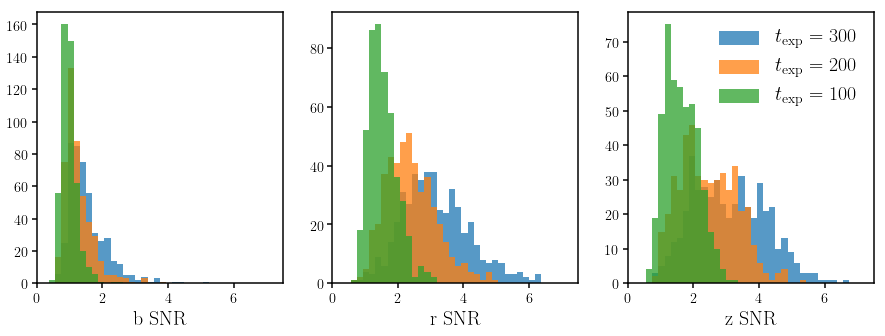

In [11]:
fig = plt.figure(figsize=(15,5))
for i, band in enumerate(['b', 'r', 'z']): 
    sub = fig.add_subplot(1,3,1+i)
    for _i in range(len(simspecs)): 
        sub.hist(snrs[_i, i,:], range=(0, 7.5), bins=40, color='C%i' % _i, alpha=0.75, label=r'$t_{\rm exp} = %.f$' % texps[_i])
        print('texp = %.f %s band median SNR=%.2f' % (texps[_i], band, np.median(snrs[_i,i,:])))
    sub.set_xlabel(band+' SNR', fontsize=20)
    sub.set_xlim([0., 7.5])
    if i == 2: sub.legend(loc='upper right', fontsize=20)